In [1]:
pip install git+https://github.com/mwaskom/seaborn.git


  Cloning https://github.com/mwaskom/seaborn.git to /private/var/folders/tz/vjwk136j1mg9xs5sw7m71s8m0000gn/T/pip-req-build-afs1gqxy
  Running command git clone -q https://github.com/mwaskom/seaborn.git /private/var/folders/tz/vjwk136j1mg9xs5sw7m71s8m0000gn/T/pip-req-build-afs1gqxy
  Created wheel for seaborn: filename=seaborn-0.11.0.dev0-cp37-none-any.whl size=254818 sha256=df06752c98998d80596dab182e198bac31d1bdf1f81276af253abcc56d5daff4
  Stored in directory: /private/var/folders/tz/vjwk136j1mg9xs5sw7m71s8m0000gn/T/pip-ephem-wheel-cache-8v5gu7_g/wheels/4e/57/af/138c7bf2390a67f7010588cf080fb8b4e741bb290c2ad12018
Successfully built seaborn
  Found existing installation: seaborn 0.9.0
    Uninstalling seaborn-0.9.0:
      Successfully uninstalled seaborn-0.9.0
Note: you may need to restart the kernel to use updated packages.


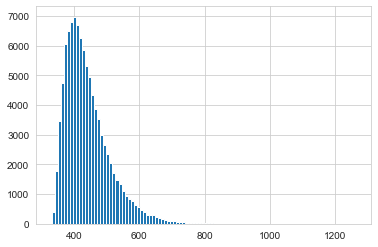

0.83411


In [129]:
#Mock up of Monte Carlo simulation to predict MND diagnosis times
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import kstest

sns.set_style('whitegrid')

def pathway_simulation(s2gp, gp2neuro, neuro2diagnosis, nsim, threshold):
    '''
    #Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
#will dictate what the distributions, mean, SD etc are. 

# UNITS ARE IN DAYS

    Args:
        s2gp (1x2 array): mean and SD of time taken from symptom onset to presentation to first medical contact
        gp2neuro (1x2 array): mean and SD of time taken from gp to neurology appointment
        neuro2diagnosis (1x2 array): mean and SD of time taken from neurology appointment to diagnosis
        nsim (scalar): number of simulation in Monte Carlo simulation
        Threshold (scalar): proportion of people are seen in 'threshold' amount of time

    '''
    # PRECOVID model NEED TO ADJUST THESE AND RENAME
    # Figures from https://www.jns-journal.com/action/showPdf?pii=S0022-510X%2820%2930391-9
    # Based on 64 patients in Barts in 2000
    symptom_to_gp = gamma(1, loc = s2gp[0], scale = s2gp[1]) 
    gp_to_neuro = gamma(1, loc = gp2neuro[0], scale = gp2neuro[1])
    neuro_to_diagnosis = gamma(1, loc = neuro2diagnosis[0], scale = neuro2diagnosis[1])

    #Number of simulations
    number_of_simulations = nsim

    #This is the Monte Carlo simulation bit
    symptom_to_gp_times = symptom_to_gp.rvs(number_of_simulations)
    gp_to_neuro_times = gp_to_neuro.rvs(number_of_simulations)
    neuro_to_diagnosis_times = neuro_to_diagnosis.rvs(number_of_simulations)

    #Put it all together in a dataframe
    data = pd.DataFrame({
        "symptom_to_gp_times": symptom_to_gp_times,
        "gp_to_neuro_times": gp_to_neuro_times,
        "neuro_to_diagnosis_times": neuro_to_diagnosis_times
    })

    #Below is the overall equation for calculating the variable of interest
    data["total_time"] = data.symptom_to_gp_times + data.gp_to_neuro_times + data.neuro_to_diagnosis_times

    #Plotting the overall distribution of times taken to go through the clinical pathway. Note that we can plot each step.
    plt.hist(data.total_time, bins = 100)
    plt.show()

    #gives probability that someone who goes through this pathway is seen in less than 400 days
    print(data[data["total_time"] < threshold].count()["total_time"] / nsim)

    return

peacetime = pathway_simulation([90,30], [180,60],[60,20], nsim = 100000, threshold = 500)

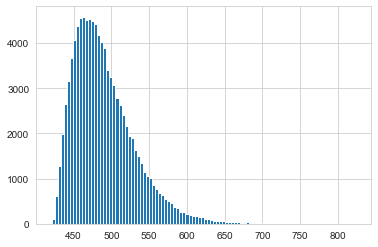

0.66592


In [130]:
# COVID model
# Just run function and insert values for mean and SD of each step.
# No need for best and worst case scenario; plugging in the numbers should give us a probability distribution during
# COVID and looking at the distribution of times should tell us the best and worse case scenarios.
covid = pathway_simulation([120,30], [240,20],[60,20], nsim = 100000, threshold = 500)

# COVID model - 2nd lock down
# This is a bit trickier to define. What does a second lockdown mean? How do we factor in a backlog of patients?

# clinical phenotypes times and classification from BMJ Open. 2016; 6(9): e012054.
#Published online 2016 Sep 30. doi: 10.1136/bmjopen-2016-012054

# https://www.tandfonline.com/doi/full/10.1080/21678421.2017.1353098

#mnd_bulbar = gamma(loc = 300, scale = 5) # NEED TO ADJUST BUT IMPORTANT THAT ITS GAMMA 
#mnd_cervical = gamma(loc = 330, scale = 30)
#mnd_lumbar = gamma(loc = 365, scale = 30)
#mnd_flail_arm = gamma(loc = 420, scale = 30)
#mnd_flail_leg = gamma(loc = 540, scale = 30)
#mnd_pls = gamma(loc = 730, scale = 30)


# see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2397016/pdf/umj7701-018.pdf

In [106]:
# https://www.england.nhs.uk/rightcare/wp-content/uploads/sites/40/2019/08/progressive-neuro-toolkit.pdf
# Target: appointments within 4 weeks of referral to a neurologist

TypeError: 'module' object is not callable

In [ ]:
#NEXT STEPS

# Timelines 
#How to work in the bottleneck/binary steps, such as "Do I attend the GP?" and "Whats the probability that my
#makes a referral to the neurologist?".

#One solution is to have a parallel pathway, which deals with the binary (yes,no) nodes. Hence instead of a
#distribution of times to reach diagnosis (as above), we will have a distribution of the number of people that
#remain in the pathway. We can multiply the "time to diagnosis" and "number of people" distributions to see what 
#proportion of people are seen within a certain time. 

#The problem with the above is that the results are representative of one iteration of going through the cycle. 
#Patient's who aren't referred by their GP get worse but inevitably go through the cycle again. The model
#above doesn't account for these returners. We could account for this by using if statements to simulate these 
#different scenarios. For example, we have the initial "Do I go to the GP?" node represented by a Bernoulli (binary)
#distribution with 90% yes and 10% no. In the Monte Carlo simulation, if the simulated person is a 'yes', their 
#GP waiting time distribution is drawn from the distribution above; if the simulated person is a 'no', then their
#GP waiting time is drawn from a 'no' distribution, which has a greater mean than the 'yes' distribution (hence
#simulating a longer waiting time). This can be done for all binary and continuous nodes, which might be a better
#way to simulate the process.